In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import opencc

from sklearn.metrics.pairwise import euclidean_distances

In [2]:
NUM_COMPLEXITY_BINS = 6
NUM_BIN_SAMPLES = 200
NUM_FULL_SAMPLES = 2000
SAMPLE_SIZE = 50
FULL_SAMPLE_SIZE = 50

PERIODS = ["Oracle", "Bronze", "Seal", "Traditional", "Simplified"]
DISTINCTIVENESS_NEIGHBOURS = 20
DISTINCTIVENESS_EXAMPLES = 10

In [3]:
embeddings = pd.read_csv("../data/distinctiveness/hccr_embeddings.csv", index_col=0)
embeddings["fc1_embedding"] = embeddings["fc1_embedding"].apply(eval)
embeddings = embeddings.rename({"character": "rendered_character"}, axis=1)
distinctiveness = pd.read_csv("../data/distinctiveness/all_distinctiveness.csv", index_col=0)
oracle_stream_characters = set(distinctiveness[distinctiveness["period"] == "Oracle"]["simplified_character"])

# Only keep Oracle stream characters
distinctiveness = distinctiveness[distinctiveness["simplified_character"].isin(oracle_stream_characters)]
embeddings = embeddings.merge(distinctiveness[["simplified_character", "perimetric_complexity", "rendered_character", "period", "image_id"]], on=["rendered_character", "period", "image_id"])


Oracle
Bronze
Seal
Traditional
Simplified
Oracle
Bronze
Seal
Traditional
Simplified


Text(0.5, -0.25, 'Complexity')

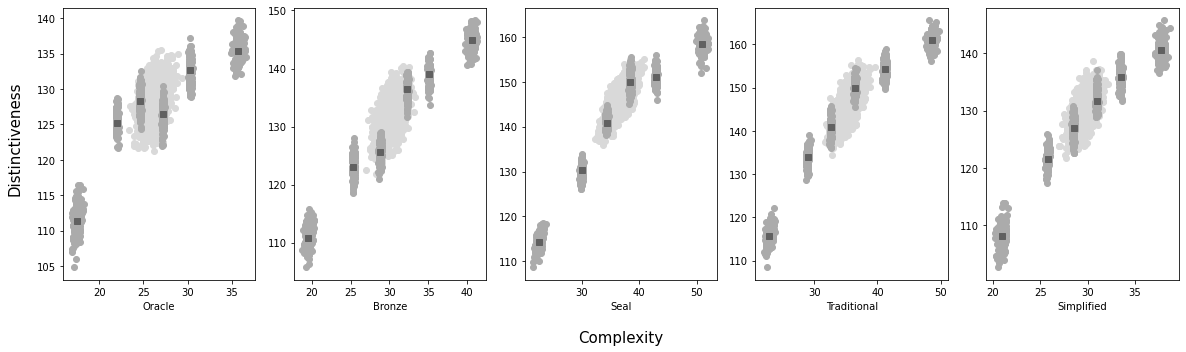

In [11]:
# Bin sampling
rows = []
for period in PERIODS:
    
    print(period)
    
    # Filter by period
    period_df = embeddings[embeddings["period"] == period]
    
    # Sort by complexity
    period_df = period_df.sort_values(by="perimetric_complexity", ascending=True).reset_index(drop=True)
    
    # Bin according to complexity
    bin_labels = list(range(NUM_COMPLEXITY_BINS))
    bins = pd.qcut(period_df["perimetric_complexity"], q=NUM_COMPLEXITY_BINS, labels=bin_labels)
    period_df["perimetric_complexity_bin"] = bins
    
    for bin_label, bin_df in period_df.groupby("perimetric_complexity_bin"):
        for i in range(NUM_BIN_SAMPLES):
            bin_sample = bin_df.sample(n=SAMPLE_SIZE)
            sample_avg_complexity = np.mean(bin_sample["perimetric_complexity"])
            
            distances = euclidean_distances(bin_sample["fc1_embedding"].tolist())
            distinctiveness_scores = []
            for d in distances:
                distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
            sample_avg_distinctiveness = np.mean(distinctiveness_scores)
            
            rows.append((period, bin_label, i, sample_avg_complexity, sample_avg_distinctiveness))
            
bin_df = pd.DataFrame(rows, columns=["period", "bin", "sample_num", "sample_average_complexity", "sample_average_distinctiveness"])


# Full sampling
rows = []
for period in PERIODS:
    
    print(period)
    
    period_df = embeddings[embeddings["period"] == period]
    
    for i in range(NUM_FULL_SAMPLES):
        full_sample = period_df.sample(n=FULL_SAMPLE_SIZE)
        sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])
        
        distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
        distinctiveness_scores = []
        for d in distances:
            distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
        sample_avg_distinctiveness = np.mean(distinctiveness_scores)
        
        rows.append((period, i, sample_avg_complexity, sample_avg_distinctiveness))
        
full_df = pd.DataFrame(rows, columns=["period", "sample_num", "sample_average_complexity", "sample_average_distinctiveness"])


# Plot figure
fig, axes = plt.subplots(1,len(PERIODS),figsize=(20,5))

for i, period in enumerate(PERIODS):
    period_bin_df = bin_df[bin_df["period"] == period]
    period_full_df = full_df[full_df["period"] == period]
    
    # Calculate median points for each bin
    bin_complexity_medians = [np.median(bdf["sample_average_complexity"]) for _, bdf in period_bin_df.groupby("bin")]
    bin_distinctiveness_medians = [np.median(bdf["sample_average_distinctiveness"]) for _, bdf in period_bin_df.groupby("bin")]
    
    axes[i].scatter(x=period_full_df["sample_average_complexity"], y=period_full_df["sample_average_distinctiveness"], color="#d9d9d9")
    axes[i].scatter(x=period_bin_df["sample_average_complexity"], y=period_bin_df["sample_average_distinctiveness"], color="#ababab")

    axes[i].set_xlabel(period)
    axes[i].set_ylabel("")

    axes[i].plot(bin_complexity_medians, bin_distinctiveness_medians, "s", color="#616161")

axes[0].set_title("Distinctiveness", fontsize=15, rotation="vertical", x=-0.25, y=0.3)
axes[2].set_title("Complexity", fontsize=15, y=-0.25)

In [11]:
#rows = []
for sample_size in range(500, 501, 25):
    print(sample_size)
    for period in PERIODS:

        print(period)

        period_df = embeddings[embeddings["period"] == period]

        for i in range(NUM_FULL_SAMPLES):
            full_sample = period_df.sample(n=sample_size)
            sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])

            distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
            distinctiveness_scores = []
            for d in distances:
                distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
            sample_avg_distinctiveness = np.mean(distinctiveness_scores)

            rows.append((sample_size, period, i, sample_avg_complexity, sample_avg_distinctiveness))

500
Oracle
Bronze
Seal
Traditional
Simplified


In [12]:
sample_df = pd.DataFrame(rows, columns=["sample_size", "period", "sample_num", "sample_avg_complexity", "sample_avg_distinctiveness"])

Oracle
Bronze
Seal
Traditional
Simplified


<AxesSubplot:xlabel='period', ylabel='distinctiveness'>

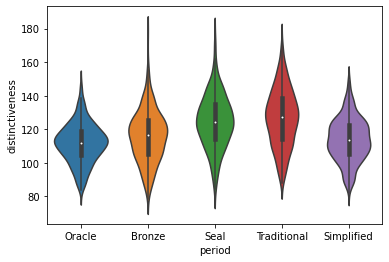

In [38]:
rows = []
for period in PERIODS:

    print(period)

    period_df = embeddings[embeddings["period"] == period]

    full_sample = period_df
    sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])

    distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
    for i, d in enumerate(distances):
        rows.append((period, full_sample.iloc[i]["rendered_character"], np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1])))

oracle_distinctiveness = pd.DataFrame(rows, columns=["period", "character", "distinctiveness"])
sns.violinplot(x="period", y="distinctiveness", data=oracle_distinctiveness)

In [34]:
for p, pdf in distinctiveness.groupby("period"):
    print(p, pdf.shape)

Bronze (517, 9)
Oracle (651, 9)
Seal (618, 9)
Simplified (648, 9)
Traditional (647, 9)


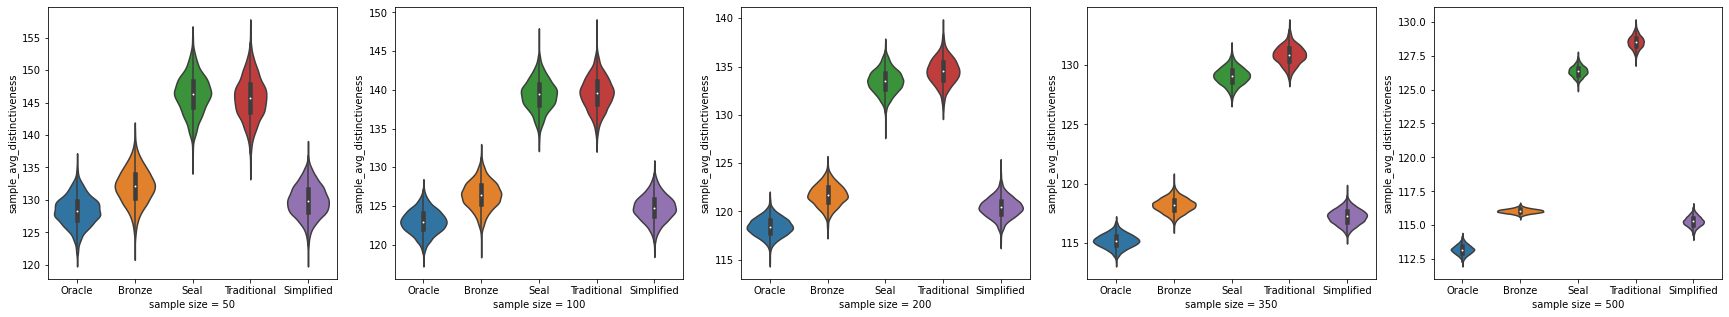

In [26]:
fig, axes = plt.subplots(1,5,figsize=(30,5))

SAMPLE_SIZES = [50,100,200,350,500]
for i, ss in enumerate(SAMPLE_SIZES):
    sns.violinplot(x="period", y="sample_avg_distinctiveness", data=sample_df[sample_df["sample_size"] == ss], ax=axes[i])
    axes[i].set_xlabel(f"sample size = {ss}")

In [20]:
rows = []
for ss, sdf in sample_df.groupby("sample_size"):
    for p in PERIODS:
        pdf = sdf[sdf["period"] == p]
        rows.append((ss, p, np.mean(pdf["sample_avg_distinctiveness"]), np.std(pdf["sample_avg_distinctiveness"])))
avg_sample_df = pd.DataFrame(rows, columns=["sample_size", "period", "average_sample_distinctiveness", "std_sample_distinctiveness"])

<AxesSubplot:xlabel='sample_size', ylabel='std_sample_distinctiveness'>

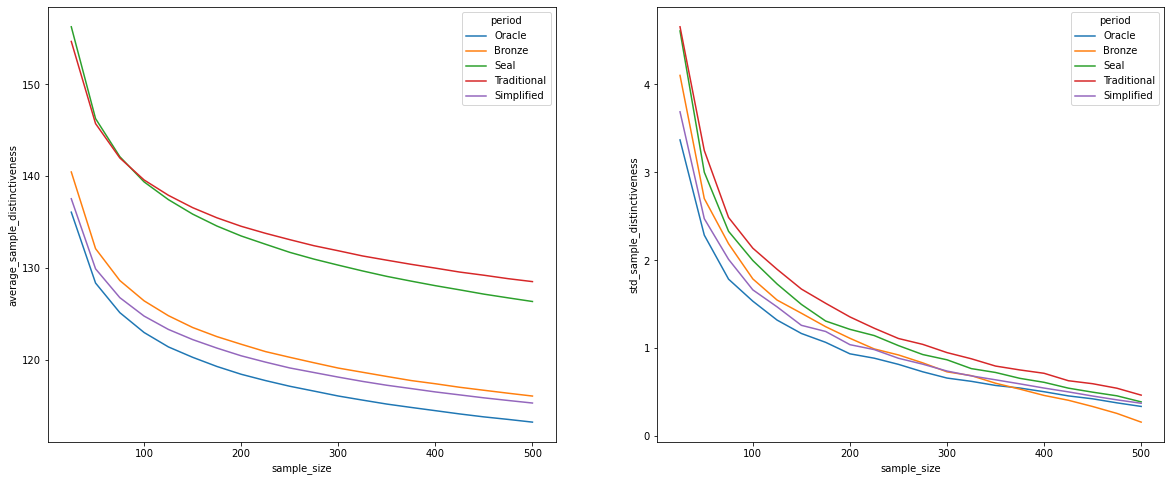

In [22]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.lineplot(x="sample_size", y="average_sample_distinctiveness", hue="period", data=avg_sample_df, ax=axes[0])
sns.lineplot(x="sample_size", y="std_sample_distinctiveness", hue="period", data=avg_sample_df, ax=axes[1])

In [14]:
bin_df.to_csv("bin_distinctiveness_samples.csv")
full_df.to_csv("full_distinctiveness_samples.csv")

651
(3081, 14)


<ipython-input-12-c6cbe1d060a7>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(DISTINCTIVENESS_BIN_LABELS)
<ipython-input-12-c6cbe1d060a7>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Oracle','Bronze','Seal','Traditional','Simplified'][::-1])


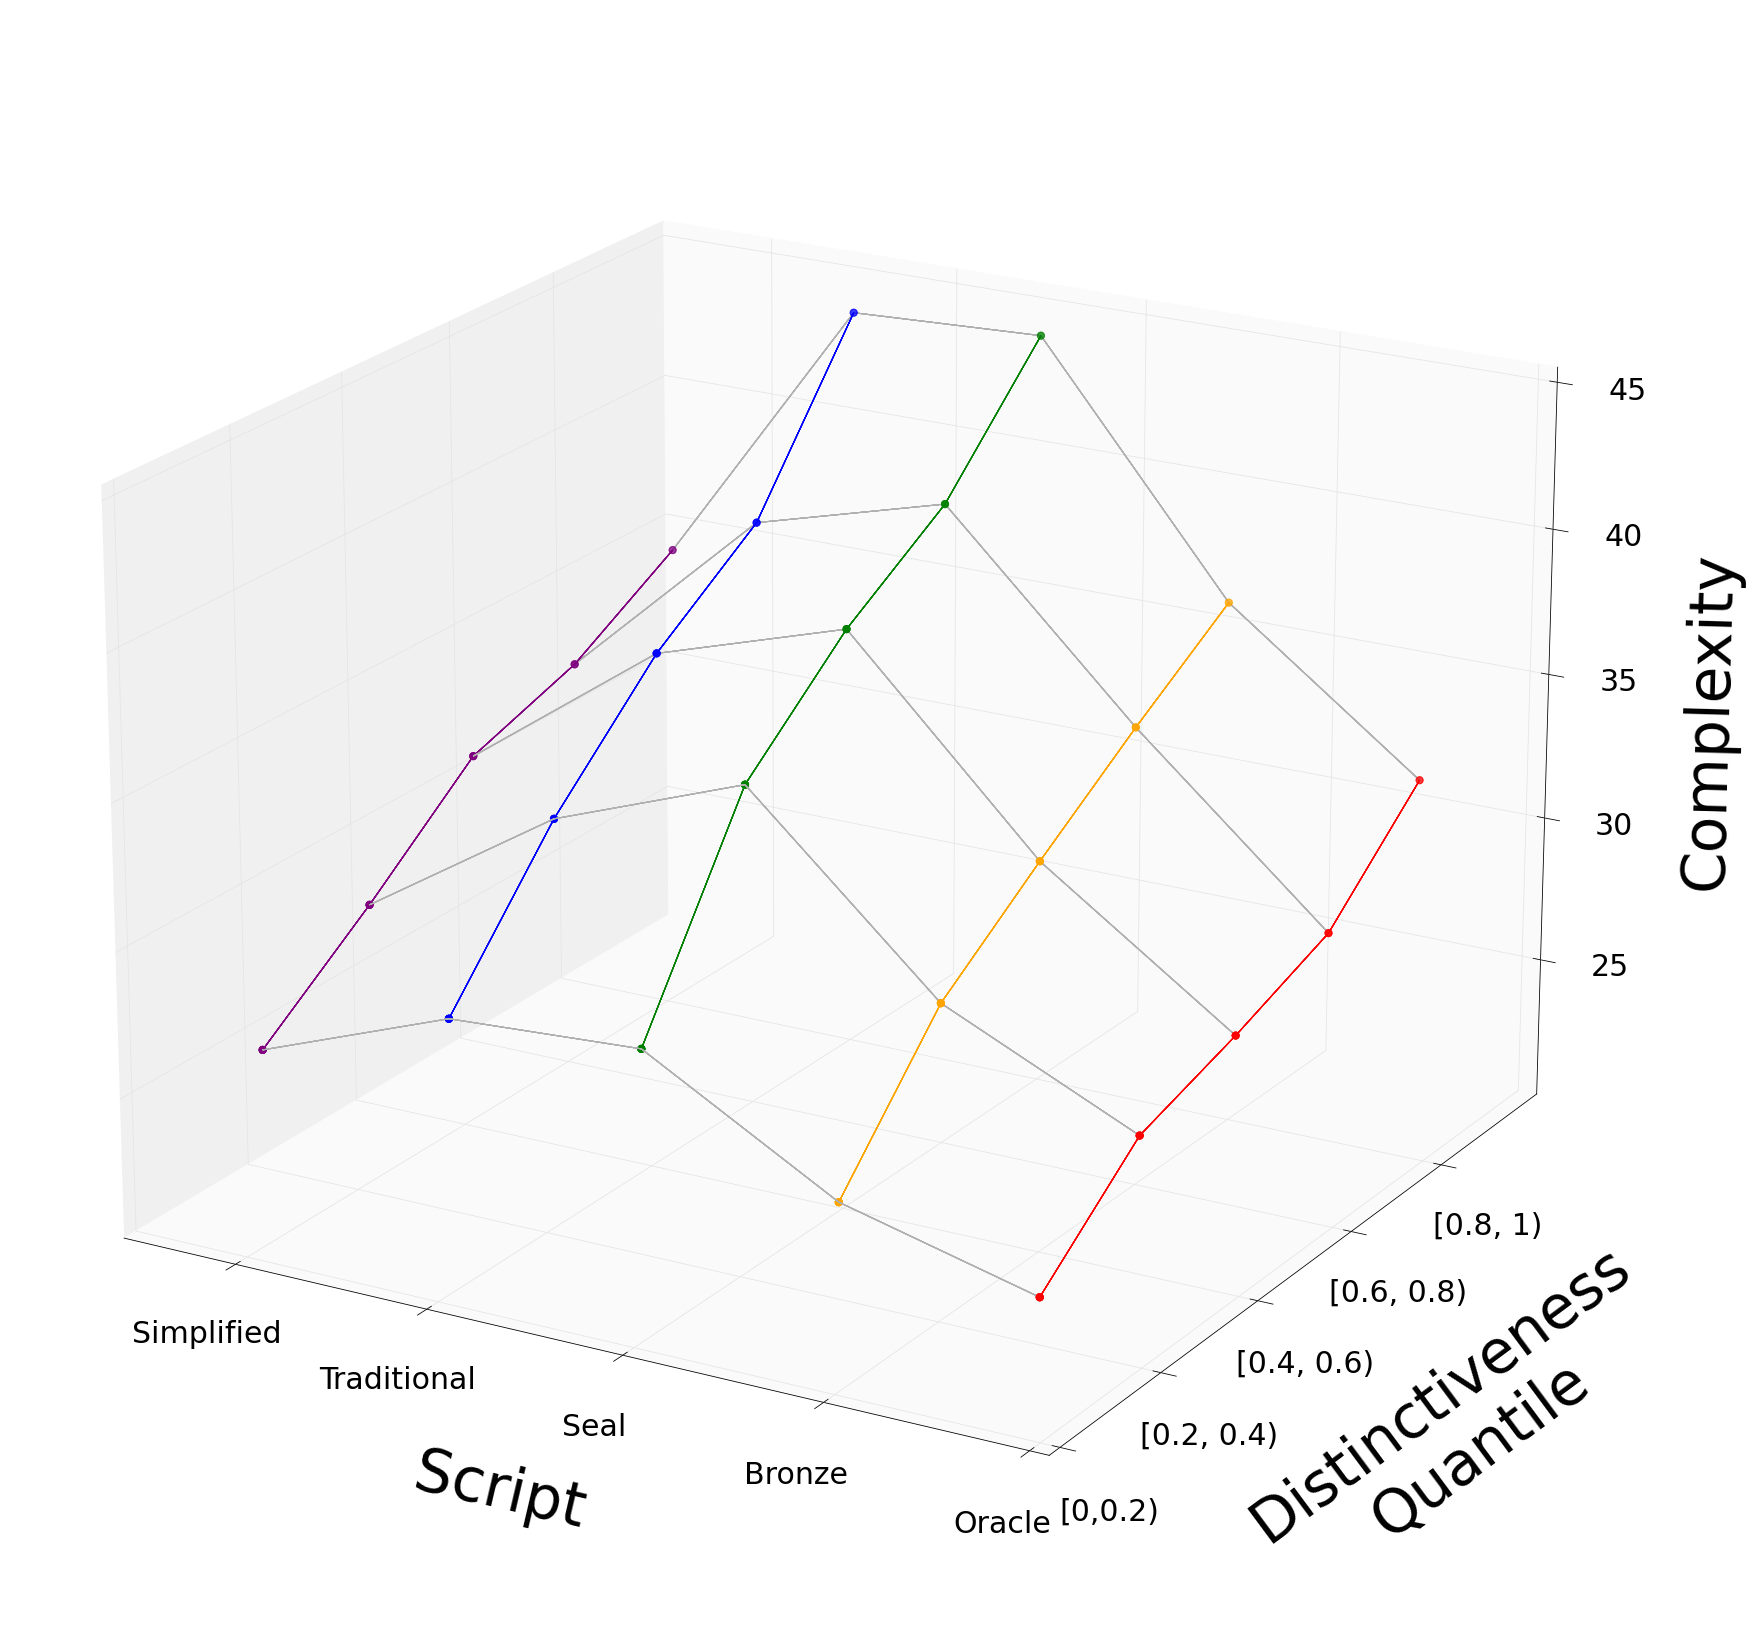

In [12]:
CMAP = {"Oracle":"red","Bronze":"orange","Seal":"green","Traditional":"blue", "Simplified":"purple"}
FREQ_TYPES = ["AdjustedC1Frequency bin", "C1Frequency bin"]
LISTDIR = lambda x: [i for i in os.listdir(x) if i != ".DS_Store"]
PMAP = {"Oracle":0,"Bronze":1,"Seal":2,"Traditional":3, "Simplified":4}
flatten = lambda l:[item for sublist in l for item in sublist]
DISTINCTIVENESS_BIN_LABELS = {"[0,0.2)":0, "[0.2, 0.4)":1, "[0.4, 0.6)":2, "[0.6, 0.8)":3, "[0.8, 1)":4}


distinctiveness = pd.read_csv("../data/distinctiveness/all_distinctiveness.csv", index_col=0)
cld = pd.read_csv("../data/cld.csv", index_col=0)

# Add complexity file's original->simplified mappings to cld data
#t2s = {row["rendered_character"]:row["simplified_character"] for _, row in complexities_single.iterrows()}
t2s = opencc.OpenCC("t2s.json")
cld["simplified_character"] = [t2s.convert(i) for i in cld["Character"]]

data = cld.merge(distinctiveness.drop("rendered_character", axis=1), on=["simplified_character"]).drop("simplified_character", axis=1)

# Only keep characters that were present in the oracle stream
oracle_characters = set(data[data["period"] == "Oracle"]["Character"])
print(len(oracle_characters))
data = data[data["Character"].isin(oracle_characters)]
print(data.shape)
data.head()

# Within each period, bin distinctiveness into pentiles
bin_map = {}
for p, pdf in data.groupby("period"):
    distinctiveness_bins = pd.qcut(pdf["distinctiveness"], q=5, labels=DISTINCTIVENESS_BIN_LABELS)
    for i, row in pdf.iterrows():
        bin_map[row["Character"] + p] = distinctiveness_bins[i]
data["Distinctiveness bin"] = [bin_map[row["Character"] + row["period"]] for _, row in data.iterrows()]
data["Distinctiveness bin num"] = data["Distinctiveness bin"].apply(lambda x: DISTINCTIVENESS_BIN_LABELS[x])

# # Make sure bins have enough characters in them
# MIN_BIN_SIZE = 5
# for d, ddf in data.sort_values(by="Distinctiveness bin").groupby(["period", "Distinctiveness bin"]):
#     print(d, len(ddf["Character"].unique()))
        
            
fig, ax = plt.subplots(figsize=(30,30), subplot_kw={'projection': '3d'})
plt.rcParams['grid.color'] = "#E5E5E5"

rows = []
for lb, lbdata in data.groupby("Distinctiveness bin num"):
    for period in PERIODS:
        rows.append((lb, period, np.mean(lbdata[lbdata["period"]==period]["perimetric_complexity"])))
lbcdf = pd.DataFrame(rows, columns=["Distinctiveness bin num", "period", "average complexity"])
lbcdf["period rank"] = [PMAP[i] for i in lbcdf["period"]]

#ax = fig.add_subplot(1, 1, 1, projection='3d')
for f,fdata in lbcdf.sort_values(by="Distinctiveness bin num").groupby("Distinctiveness bin num"):
    fdf = fdata.sort_values(by="period rank")
    for i in range(0, fdf.shape[0]-1):
        ax.plot_wireframe(fdf["period rank"],fdf["Distinctiveness bin num"]*np.ones(fdf.shape[0]),np.array([fdf["average complexity"],fdf["average complexity"]]),color="#b0b0b0",linewidth=1)

for p,pdata in lbcdf.sort_values(by="period rank").groupby("period"):
    pdf = pdata.sort_values(by="Distinctiveness bin num")
    for i in range(0, pdf.shape[0]-1):
        ax.plot_wireframe(pdf["period rank"].iloc[0]*np.ones(pdf.shape[0]),pdf["Distinctiveness bin num"],np.array([pdf["average complexity"],pdf["average complexity"]]),color=CMAP[p],linewidth=1)
        ax.scatter3D(pdf["period rank"].iloc[0]*np.ones(pdf.shape[0]),pdf["Distinctiveness bin num"],pdf["average complexity"],color=CMAP[p],s=50)

ax.set_xlabel('Script')
ax.set_ylabel('Distinctiveness\nQuantile')
ax.set_zlabel('Complexity')

ax.set_yticklabels(DISTINCTIVENESS_BIN_LABELS)
ax.set_xticklabels(['Oracle','Bronze','Seal','Traditional','Simplified'][::-1])

ax.set_ylim(-1,4)
ax.set_yticks(np.arange(-1, 4, 1.0))

ax.invert_xaxis()
ax.set_xlim(4, -0.5)
ax.set_xticks(np.arange(3.5, -1, -1.0))
#ax.set_xlim(-0.5,3.5)

ax.xaxis.label.set_fontweight("medium")
ax.yaxis.label.set_fontweight("medium")
ax.zaxis.label.set_fontweight("medium")

ax.view_init(20,-60)
ax.w_xaxis.set_pane_color((240/255,240/255,240/255,1))
ax.w_yaxis.set_pane_color((250/255,250/255,250/255,1))
ax.w_zaxis.set_pane_color((250/255,250/255,250/255,1))

ax.xaxis.labelpad = 90
ax.yaxis.labelpad = 120
ax.zaxis.labelpad = 80

ax.tick_params(axis="both", labelsize=30,pad=35)

ax.xaxis.label.set_fontsize(60)
ax.yaxis.label.set_fontsize(60)
ax.zaxis.label.set_fontsize(60)

#ax.xaxis.set_ticks(np.arange(0,len(PERIODS),1))

# #plt.xticks(rotation=0)
# ax.set_ylim(3.5,1)
# ax.set_yticks(range(5,-1,-1))
# ax.set_xlim(4,0)